# 3. Visualize (Part 19)

# Imports

In [1]:
from IPython.display import Audio, Markdown
import datetime
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import obspy
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, iirnotch, filtfilt, stft

## Parameters

In [2]:
input_raw_path = '../data/raw/remote'
input_processing_path = '../data/interim/remote'
output_path = '../data/interim/remote'
label_field = 'time_abs(%Y-%m-%dT%H:%M:%S.%f)'

## Load dataset

In [3]:
input_df = pd.read_csv(f'{input_processing_path}/1_processing.csv')
input_df

,Unnamed: 0,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type,body,subset,mseed_path,mseed_sampling_rate,mseed_starttime,mseed_endtime,mseed_calib,mseed_network,mseed_station,mseed_location,mseed_channel,mseed_hash
0,0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq,Moon,train,../data/raw/remote/space_apps_2024_seismic_det...,6.625,1970-01-19T00:00:00.665000Z,1970-01-20T00:00:02.778208Z,1.0,XA,S12,0,MHZ,17920d9749c100bd48b3ca4ff27c3e61
1,1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq,Moon,train,../data/raw/remote/space_apps_2024_seismic_det...,6.625,1970-03-25T00:00:00.440000Z,1970-03-26T00:00:01.949434Z,1.0,XA,S12,0,MHZ,1d2e9c5e65c52b306f3d6e9240c992fe
2,2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq,Moon,train,../data/raw/remote/space_apps_2024_seismic_det...,6.625,1970-03-26T00:00:00.565000Z,1970-03-27T00:00:02.074434Z,1.0,XA,S12,0,MHZ,7e3c8e7fb53090bdcfb94034862309f0
3,3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq,Moon,train,../data/raw/remote/space_apps_2024_seismic_det...,6.625,1970-04-25T00:00:00.196000Z,1970-04-26T00:00:02.309208Z,1.0,XA,S12,0,MHZ,75f575f5d3b78a4fe55dd51d47ef162a
4,4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq,Moon,train,../data/raw/remote/space_apps_2024_seismic_det...,6.625,1970-04-26T00:00:00.660000Z,1970-04-27T00:00:02.169434Z,1.0,XA,S12,0,MHZ,e6a0ee72e5eb3a8e4d3162195312c14f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,4,XB.ELYSE.02.BHV.2021-05-02HR01_evid0017,NaN,NaN,evid0017,NaN,Mars,test,../data/raw/remote/space_apps_2024_seismic_det...,20.000,2021-05-02T01:00:00.025000Z,2021-05-02T01:59:59.975000Z,1.0,XB,ELYSE,2,BHV,c01f6f835542c10de052132068e599f1
179,5,XB.ELYSE.02.BHV.2021-10-11HR23_evid0011,NaN,NaN,evid0011,NaN,Mars,test,../data/raw/remote/space_apps_2024_seismic_det...,20.000,2021-10-11T23:00:00.039000Z,2021-10-11T23:59:59.989000Z,1.0,XB,ELYSE,2,BHV,50341b5f2e88611d01d15d4ff9ad3e65
180,6,XB.ELYSE.02.BHV.2021-12-24HR22_evid0007,NaN,NaN,evid0007,NaN,Mars,test,../data/raw/remote/space_apps_2024_seismic_det...,20.000,2021-12-24T22:00:00.041000Z,2021-12-24T22:59:59.991000Z,1.0,XB,ELYSE,2,BHV,7526a37834109b3a951f85c790d2bad3
181,7,XB.ELYSE.02.BHV.2022-04-09HR22_evid0002,NaN,NaN,evid0002,NaN,Mars,test,../data/raw/remote/space_apps_2024_seismic_det...,20.000,2022-04-09T22:00:00.035000Z,2022-04-09T22:59:59.985000Z,1.0,XB,ELYSE,2,BHV,652032887b50ec8cc74997ef038472d0


## Utilities

In [4]:
def play_trace(trace, target_freq=40):
    # trace = trace.copy()
    rate_coef = trace.stats.sampling_rate / target_freq

    # Step 3: Resample the data (Optional, to match audio sample rate, e.g., 44100 Hz)
    # desired_sample_rate = rate_coef * 44100  # Standard audio sample rate
    # trace.resample(sampling_rate=desired_sample_rate)
    
    # Step 4: Normalize the data to the range [-1, 1] for audio playback
    data = trace.data.astype(np.float32)
    data /= np.max(np.abs(data))  # Normalize to [-1, 1]
    
    # Step 5: Play the audio
    display(Audio(data, rate=rate_coef * 44100))

In [5]:
def plot_spectrum(tr, axes):
    sampling_rate = tr.stats.sampling_rate
    time_series = tr.data
    
    # Assume `time_series` is your data and `sampling_rate` is the rate of data collection
    N = len(time_series)  # Number of data points
    T = 1.0 / sampling_rate  # Time interval between samples
    
    # Compute the FFT of the time series
    fft_result = fft(time_series)

    # Get the corresponding frequencies
    frequencies = fftfreq(N, T)
    
    # Take the absolute value to find the magnitude of each frequency
    magnitude = np.abs(fft_result)
    frequencies = np.abs(frequencies)
    middle = magnitude.shape[0] // 2
    magnitude = magnitude[middle:]
    frequencies = frequencies[middle:]
    # Find peaks in the FFT magnitude spectrum
    # peaks, _ = find_peaks(magnitude, height=threshold_value)
    
    threshold_value = np.percentile(magnitude, 99.99)
    peaks, _ = find_peaks(magnitude, height=threshold_value)
    
    #peaks
    ax = axes[0]
    ax.plot(frequencies, magnitude)
    for x in peaks:
        ax.axvline(x=frequencies[x], c='green')
    ax.set_title(f'Spectrum', fontweight='bold')

    f, t, Zxx = stft(time_series, sampling_rate, nperseg=200)
    y = np.percentile(np.abs(Zxx / Zxx.max(axis=0)), 50, axis=1)
    skip = 10
    ax = axes[1]
    ax.plot(f[skip:], y[skip:])
    ax.set_title(f'Spectrum (Normalized)', fontweight='bold')
    ax.set_xlabel(f'Frequency', fontweight='bold')

In [6]:
def plot_spectrogram(trace, ax):
    tr_times_filt = trace.times()
    tr_data_filt = trace.data
    
    f, t, sxx = signal.spectrogram(tr_data_filt, trace.stats.sampling_rate)

    # Plot the spectrogram
    ## ignore outliers
    vmin = np.percentile(sxx, 1)
    vmax = np.percentile(sxx, 99.9)
    vals = ax.pcolormesh(t, f, sxx, cmap=cm.jet, vmin=vmin, vmax=vmax)
    ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
    ax.set_xlabel(f'Time (s)', fontweight='bold')
    ax.set_ylabel('Frequency (Hz)', fontweight='bold')
    # ax.axvline(x=arrival, c='red')
    cbar = plt.colorbar(vals, orientation='horizontal')
    cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')
    return ax

## Show all events
### Findings
- almost all events have permanent noise around specific frequenties (for Moon data it is somethign just a little bit below 1Hz and for Mars data there are 2 noticible picks around 4Hz and 6Hz). Q: Could we improve prediction by removing around these frequencies by using something like (Notch Filter)?
- we have different scale of events for Moon and Mars, Moon event last few hours, but Mars it fades in fraction of hour
- the most interesting signal is located below 3Hz which align with low resolution of Moon data

### 2022-02-03T08:00:00.009000Z / Mars

filename: XB.ELYSE.02.BHV.2022-02-03HR08_evid0005
1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-02-03T08:00:00.009000Z - 2022-02-03T08:59:59.959000Z | 20.0 Hz, 72000 samples
--------------------------------------------------------------------------------
         network: XB
         station: ELYSE
        location: 02
         channel: BHV
       starttime: 2022-02-03T08:00:00.009000Z
         endtime: 2022-02-03T08:59:59.959000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 72000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 143, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 585728})
--------------------------------------------------------------------------------


- train / nan / at: 506.991

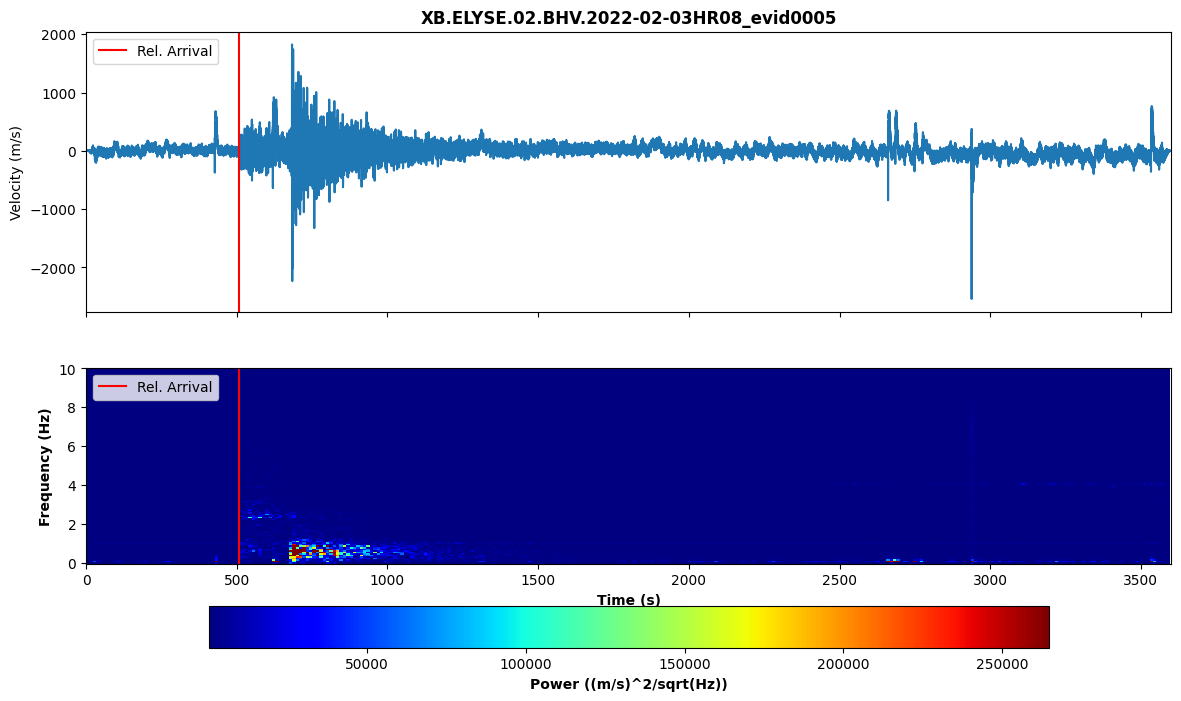

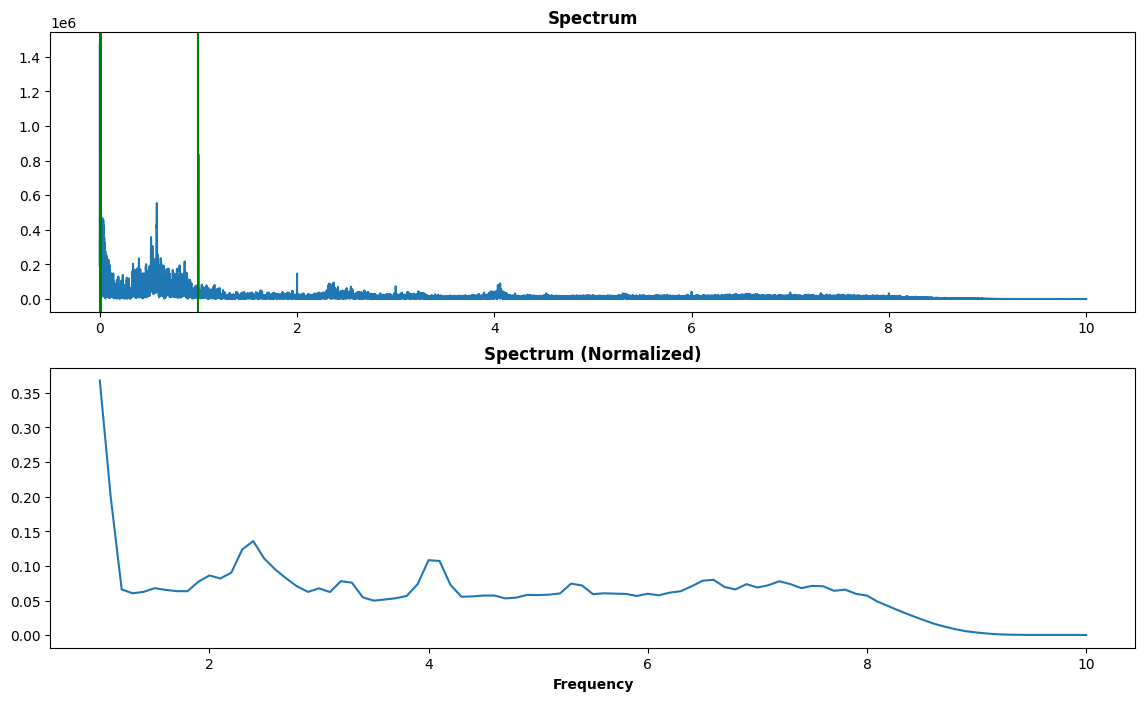

---

### 2022-04-09T22:00:00.035000Z / Mars

filename: XB.ELYSE.02.BHV.2022-04-09HR22_evid0002
1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-04-09T22:00:00.035000Z - 2022-04-09T22:59:59.985000Z | 20.0 Hz, 72000 samples
--------------------------------------------------------------------------------
         network: XB
         station: ELYSE
        location: 02
         channel: BHV
       starttime: 2022-04-09T22:00:00.035000Z
         endtime: 2022-04-09T22:59:59.985000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 72000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 143, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 585728})
--------------------------------------------------------------------------------


- test / nan / at: ?

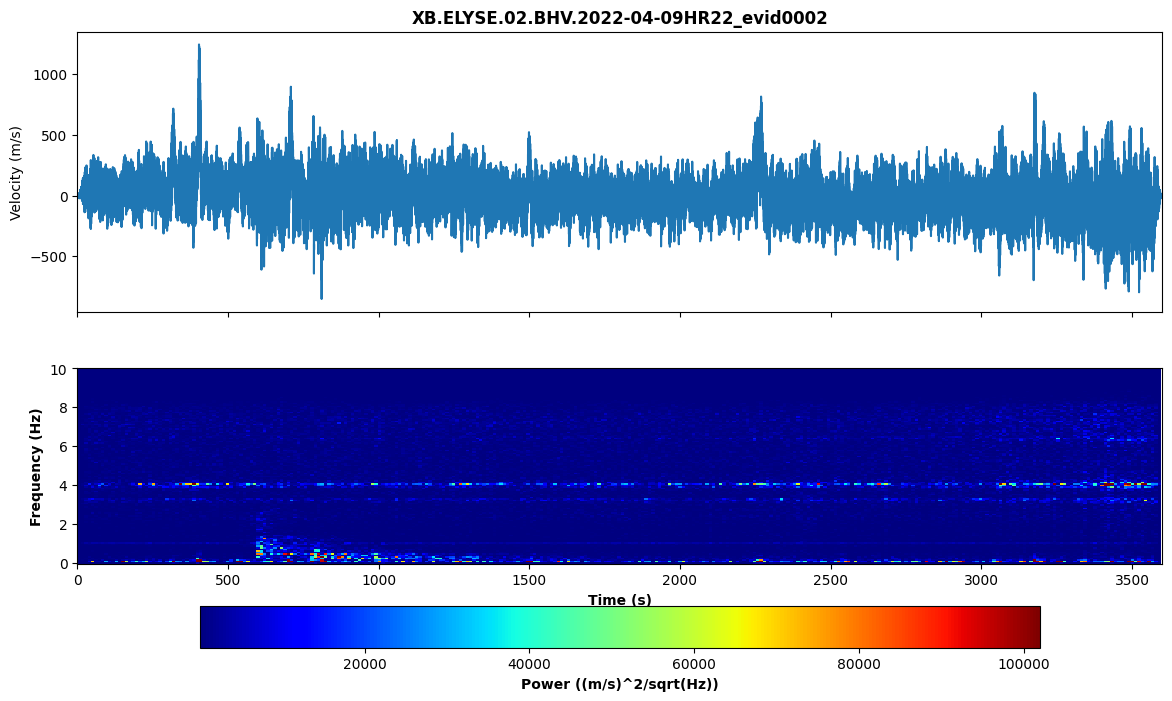

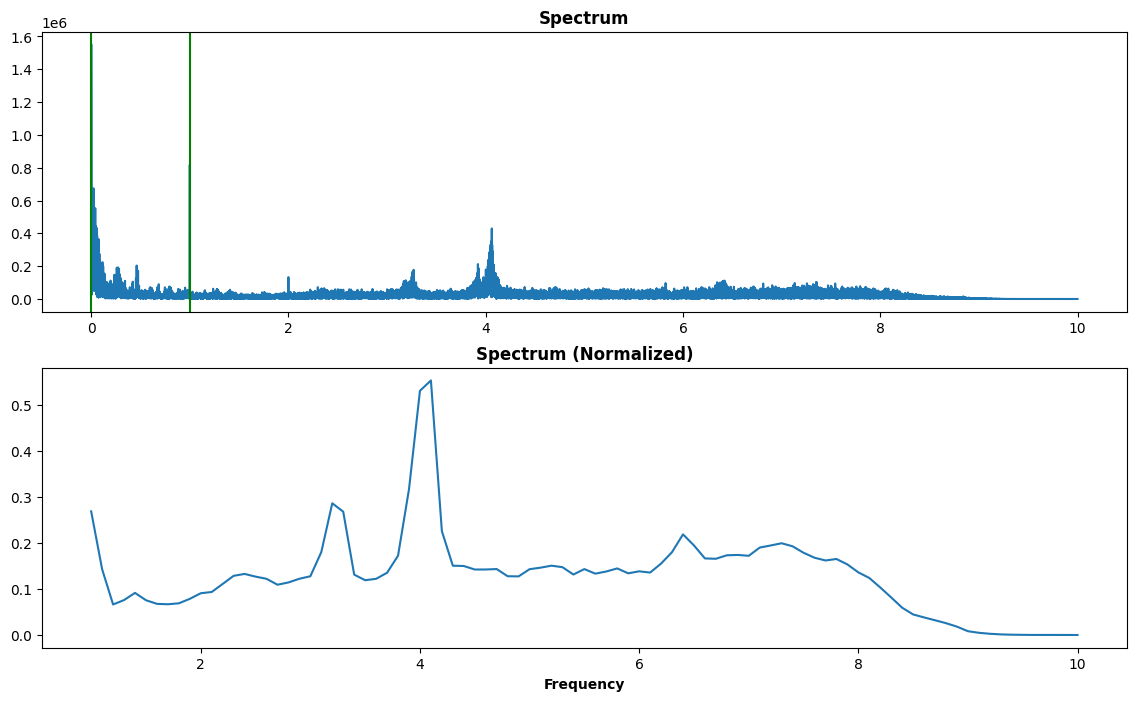

---

### 2022-05-04T23:00:00.048000Z / Mars

filename: XB.ELYSE.02.BHV.2022-05-04HR23_evid0001
1 Trace(s) in Stream:
XB.ELYSE.02.BHV | 2022-05-04T23:00:00.048000Z - 2022-05-04T23:59:59.948000Z | 20.0 Hz, 71999 samples
--------------------------------------------------------------------------------
         network: XB
         station: ELYSE
        location: 02
         channel: BHV
       starttime: 2022-05-04T23:00:00.048000Z
         endtime: 2022-05-04T23:59:59.948000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 71999
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 143, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 585728})
--------------------------------------------------------------------------------


- test / nan / at: ?

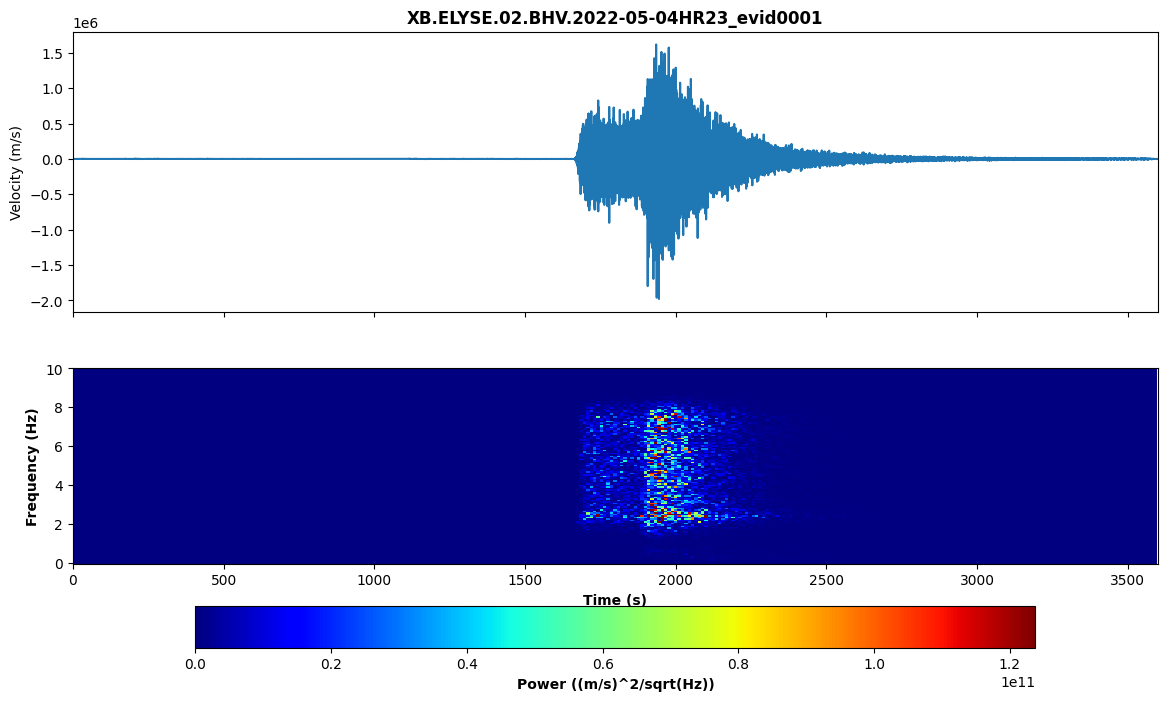

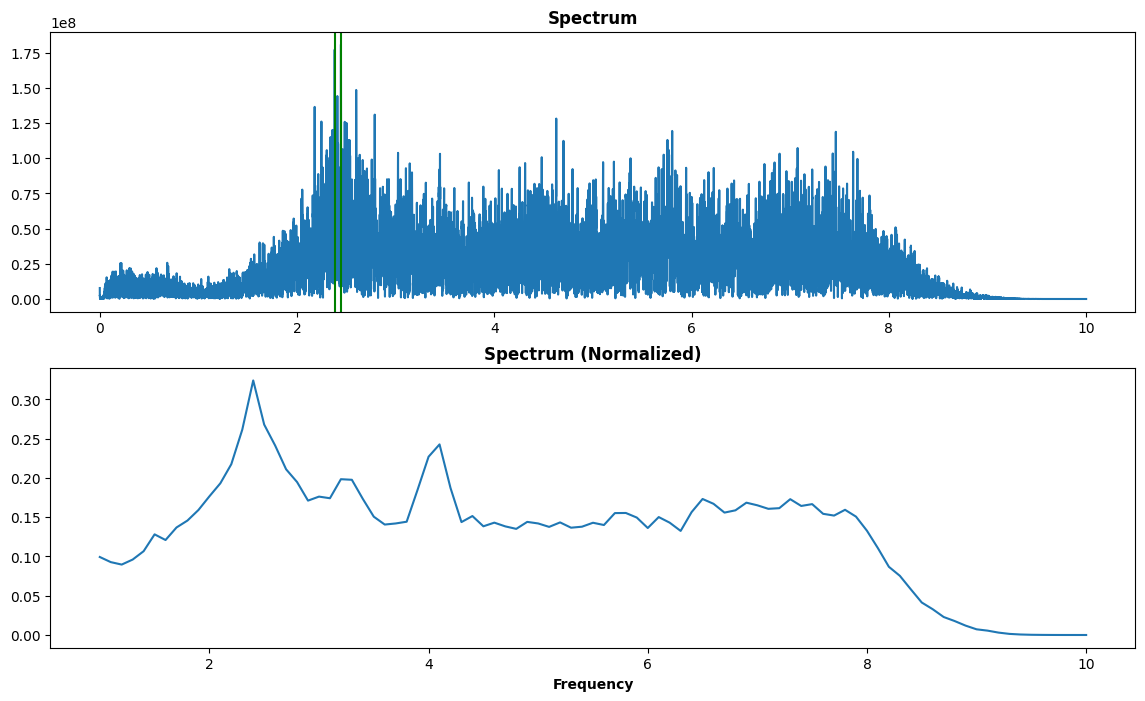

---

In [7]:
grouped = input_df.sort_values(by='mseed_starttime').iloc[180:190].groupby('mseed_path', sort=False)
for group_key, group_data in grouped:
    row = group_data.iloc[0]
    display(Markdown(f'### {group_data["mseed_starttime"].min()} / {row["body"]}'))

    filename = row['filename']
    mseed_file = row['mseed_path']

    print(f'filename: {filename}')

    st = obspy.read(mseed_file)
    print(st)
    print('-'*80)
    print(st[0].stats)
    print('-'*80)
    
    tr = st.traces[0].copy()

    # This is how you get the data and the time, which is in secondstr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data
    
    # Initialize figure
    fig, axes = plt.subplots(2, 1, figsize=(14, 2*4), sharex=True)

    ax = axes[0]
    
    # Plot trace
    ax.plot(tr_times, tr_data)
    
    # Make the plot pretty
    # ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_ylabel('Velocity (m/s)')
    # ax.set_xlabel('Time (s)')
    ax.set_title(f'{filename}', fontweight='bold')

    plot_spectrogram(tr, axes[1])

    for row_idx, row in group_data.sort_values(by='time_abs(%Y-%m-%dT%H:%M:%S.%f)').iterrows():
        
        # Start time of trace (another way to get the relative arrival time using datetime)
        starttime = tr.stats.starttime.datetime
        if row.isna()[label_field]:
            # undefined label
            arrival_time = None
            arrival = None
        else:
            arrival_time = datetime.datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
            arrival = (arrival_time - starttime).total_seconds()

        display(Markdown(f'- {row["subset"]} / {row["mq_type"]} / at: {arrival if arrival else "?"}'))
        
        # Mark detection (if we have this label)
        if arrival:
            for ax in axes:
                ax.axvline(x = arrival, color='red',label='Rel. Arrival')
                ax.legend(loc='upper left')
    
    plt.show()

    fig, axes = plt.subplots(2, 1, figsize=(14, 2*4))
    plot_spectrum(tr, axes)
    plt.show()
    
    play_trace(tr, 30)
    display(Markdown('---'))